In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import skfuzzy as fuzz
from skfuzzy import control as ctrl

/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
obstacle_distance = ctrl.Antecedent(np.arange(0, 101, 1), 'obstacle_distance')
obstacle_angle = ctrl.Antecedent(np.arange(-180, 181, 1), 'obstacle_angle')
goal_angle = ctrl.Antecedent(np.arange(-180, 181, 1), 'goal_angle')
goal_distance = ctrl.Antecedent(np.arange(0, 101, 1), 'goal_distance')
heading_change = ctrl.Consequent(np.arange(-30, 31, 1), 'heading_change')
speed = ctrl.Consequent(np.arange(0, 6, 1), 'speed')

In [3]:
obstacle_distance['close'] = fuzz.trapmf(obstacle_distance.universe, [0, 0, 3, 8])  
obstacle_distance['medium'] = fuzz.trimf(obstacle_distance.universe, [5, 15, 30])  
obstacle_distance['far'] = fuzz.trapmf(obstacle_distance.universe, [20, 50, 100, 100])

obstacle_angle['neg_large'] = fuzz.trapmf(obstacle_angle.universe, [-180, -180, -90, -45])
obstacle_angle['neg_small'] = fuzz.trimf(obstacle_angle.universe, [-90, -45, 0])
obstacle_angle['zero'] = fuzz.trimf(obstacle_angle.universe, [-5, 0, 5])
obstacle_angle['pos_small'] = fuzz.trimf(obstacle_angle.universe, [0, 45, 90])
obstacle_angle['pos_large'] = fuzz.trapmf(obstacle_angle.universe, [45, 90, 180, 180])

goal_angle['neg_large'] = fuzz.trapmf(goal_angle.universe, [-180, -180, -90, -45])
goal_angle['neg_small'] = fuzz.trimf(goal_angle.universe, [-90, -45, 0])
goal_angle['zero'] = fuzz.trimf(goal_angle.universe, [-5, 0, 5])
goal_angle['pos_small'] = fuzz.trimf(goal_angle.universe, [0, 45, 90])
goal_angle['pos_large'] = fuzz.trapmf(goal_angle.universe, [45, 90, 180, 180])

goal_distance['close'] = fuzz.trapmf(goal_distance.universe, [0, 0, 10, 20])
goal_distance['far'] = fuzz.trapmf(goal_distance.universe, [15, 30, 100, 100])

heading_change['neg_large'] = fuzz.trapmf(heading_change.universe, [-30, -30, -20, -10])
heading_change['neg_small'] = fuzz.trimf(heading_change.universe, [-20, -5, 0])
heading_change['zero'] = fuzz.trimf(heading_change.universe, [-2, 0, 2])
heading_change['pos_small'] = fuzz.trimf(heading_change.universe, [0, 5, 20])
heading_change['pos_large'] = fuzz.trapmf(heading_change.universe, [10, 20, 30, 30])

speed['slow'] = fuzz.trapmf(speed.universe, [0, 0, 1, 2])
speed['medium'] = fuzz.trimf(speed.universe, [1, 3, 4])
speed['fast'] = fuzz.trapmf(speed.universe, [3, 4, 5, 5])

In [4]:
rule1 = ctrl.Rule(obstacle_distance['close'] & obstacle_angle['neg_large'], (heading_change['pos_large'], speed['slow']))
rule2 = ctrl.Rule(obstacle_distance['close'] & obstacle_angle['pos_large'], (heading_change['neg_large'], speed['slow']))
rule3 = ctrl.Rule(obstacle_distance['medium'] & obstacle_angle['neg_small'], (heading_change['pos_small'], speed['medium']))
rule4 = ctrl.Rule(obstacle_distance['medium'] & obstacle_angle['pos_small'], (heading_change['neg_small'], speed['medium']))
rule5 = ctrl.Rule(obstacle_distance['far'] & goal_angle['neg_large'], (heading_change['neg_large'], speed['fast']))
rule6 = ctrl.Rule(obstacle_distance['far'] & goal_angle['pos_large'], (heading_change['pos_large'], speed['fast']))
rule7 = ctrl.Rule(obstacle_distance['far'] & goal_angle['zero'], (heading_change['zero'], speed['fast']))
rule8 = ctrl.Rule(goal_distance['close'], (heading_change['zero'], speed['slow']))  

In [5]:
avoidance_ctrl = ctrl.ControlSystem([rule1, rule2, rule3, rule4, rule5, rule6, rule7, rule8])
avoidance_sim = ctrl.ControlSystemSimulation(avoidance_ctrl)

uav_position = np.array([0.0, 0.0])  
goal_position = np.array([100.0, 100.0])  
uav_heading = 40  
path_x = [uav_position[0]]
path_y = [uav_position[1]]
default_speed = 1  

obstacles = [np.array([30.0, 80.0]), np.array([60.0, 40.0]), np.array([50.0, 50.0]), np.array([80.0, 80.0])]

for _ in range(1000): 
    distances = [np.linalg.norm(uav_position - obs) for obs in obstacles]
    closest_obstacle_idx = np.argmin(distances)
    closest_obstacle = obstacles[closest_obstacle_idx]
    distance = distances[closest_obstacle_idx]
    angle_to_obstacle = np.degrees(np.arctan2(closest_obstacle[1] - uav_position[1], closest_obstacle[0] - uav_position[0])) - uav_heading
    angle_to_obstacle = (angle_to_obstacle + 180) % 360 - 180

    angle_to_goal = np.degrees(np.arctan2(goal_position[1] - uav_position[1], goal_position[0] - uav_position[0])) - uav_heading
    angle_to_goal = (angle_to_goal + 180) % 360 - 180
    distance_to_goal = np.linalg.norm(uav_position - goal_position)

    avoidance_sim.input['obstacle_distance'] = distance
    avoidance_sim.input['obstacle_angle'] = angle_to_obstacle
    avoidance_sim.input['goal_angle'] = angle_to_goal
    avoidance_sim.input['goal_distance'] = distance_to_goal
    avoidance_sim.compute()

    try:
        heading_change_value = float(avoidance_sim.output['heading_change'])
        speed_value = float(avoidance_sim.output['speed'])
    except KeyError:
        heading_change_value = 0.0
        speed_value = default_speed

    uav_heading += heading_change_value
    uav_position[0] += np.cos(np.radians(uav_heading)) * speed_value
    uav_position[1] += np.sin(np.radians(uav_heading)) * speed_value

    path_x.append(uav_position[0])
    path_y.append(uav_position[1])

    if distance_to_goal < 5:
        break

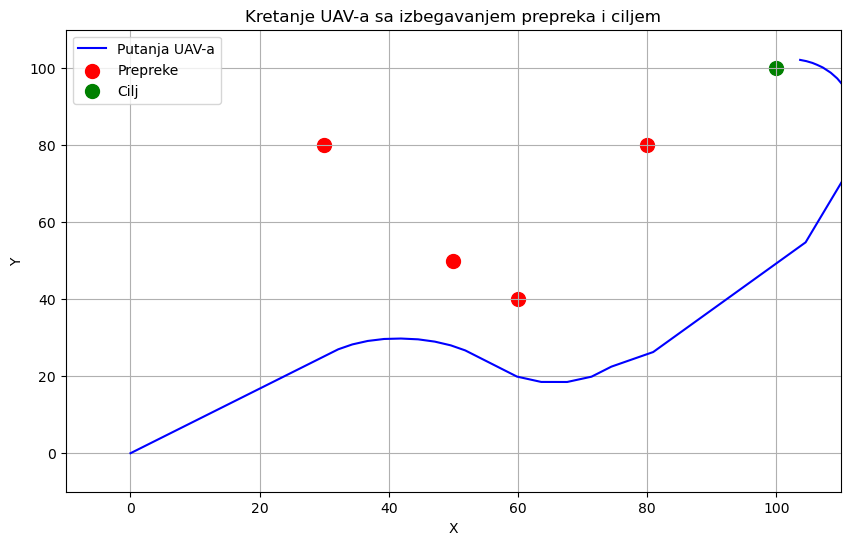

In [6]:
plt.figure(figsize=(10, 6))
plt.plot(path_x, path_y, label='Putanja UAV-a', color='blue')
plt.scatter([obs[0] for obs in obstacles], [obs[1] for obs in obstacles], color='red', s=100, label='Prepreke')
plt.scatter(goal_position[0], goal_position[1], color='green', s=100, label='Cilj')
plt.title('Kretanje UAV-a sa izbegavanjem prepreka i ciljem')
plt.xlabel('X')
plt.ylabel('Y')
plt.xlim(-10, 110)
plt.ylim(-10, 110)
plt.legend()
plt.grid(True)
plt.show()